# Lab 5

Opis: Zadanie polega na opracowaniu programu realizującego Transformację Hougha wykrywającą okręgi na obrazie rastrowym zadanym poniżej:

Etapy:

wykonanie funkcji konwersji do odcieni szarości 
wykonanie funkcji wykrywania krawędzi
wykonanie funkcji HT dla określonych z góry (przewidzianych): zakresu promieni i liczby wykrywanych okręgów
UWAGA: Proszę uwzględnić fakt, iż wybrane operacje mogą powodować powstawanie „fałszywych” detekcji. Proszę podjąć próbę rozwiązania tego problemu.  WYNIKIEM działania programu powinna być lista wykrytych okręgów (środek, promień)

$x = a + R cos(\theta)$

$y = b + R sin (\theta)$

1. oblicz R - ilość promieni do sprawdzenia robiąc R_max - R_min 
2. przygotuj sobie akumulator o rozmiarach [M, N, R] gdzie M to szerokość obrazka, N wysokość obrazka, R to ilość promieni do sprawdzenia
3. dla każdego promienia w zakresie promieniL
   3.1 dla każdego punktu białego w obrazku z wykrytymi krawędziami rysuj kółko w akumulatorze (zwiększaj akumulator o 1)
3.2 wyzeruj punkty z akumulatora które mają wartości mniejsze od 0.7 * ilosc punktów na kółeczko o aktualnym promieniu (kółeczko o promieniu 4 pewnie ma z 2*pi*4 pikseli, o promieniu r pewnie 2*pi*r) (0.7 przykładowo, opakować w zmienną), ustaw na 1 te które są wieksze
4. dla każdego akumulatora sprawdzaj zakresami (np co 5) czy punkty leżą obok siebie (aby nie rysować dużo kółek obok siebie)
5. wypisz z akumulatora punkty różne od 0 (równe 1). pierwszy indeks to współrzędna x, drugi indeks to współrzędna y, trzeci indeks to promień (trzeba dodać R_min)

In [2]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import cv2

img = plt.imread('lab5.png',0)
plt.imshow(img)

# Test z użyciem opencv

126 94 55
140 104 28
56 188 25
228 44 25
28 30 15


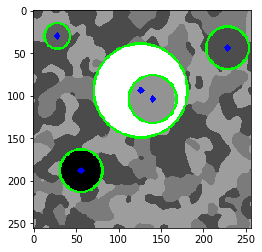

In [3]:
import cv2
import numpy as np

# Wczytanie obrazka
img = cv2.imread('lab5.png',0)
# Rozmycie obrazka
img = cv2.medianBlur(img,5)
# Odcienie szarosci
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
# Wykrywanie okregow
# Python: cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) → circles
# Parameters:
# image – 8-bit, single-channel, grayscale input image.
# circles – Output vector of found circles. Each vector is encoded as a 3-element floating-point vector  (x, y, radius) .
# circle_storage – In C function this is a memory storage that will contain the output sequence of found circles.
# method – Detection method to use. Currently, the only implemented method is CV_HOUGH_GRADIENT , which is basically 21HT , described in [Yuen90].
# dp – Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.
# minDist – Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
# param1 – First method-specific parameter. In case of CV_HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny() edge detector (the lower one is twice smaller).
# param2 – Second method-specific parameter. In case of CV_HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
# minRadius – Minimum circle radius.
# maxRadius – Maximum circle radius.
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,
                            param1=50,param2=30,minRadius=10,maxRadius=60)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # x, y, r
    print(i[0], i[1], i[2])
    # zewnetrzne kolo
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # wewnetrzne kolo
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cimg)

# Wykrywanie krawedzi obrazu

In [4]:
# Filtr
def ffilter(img, mask):
    img_new = img.copy()
    [M, N] = img.shape
    [M_mask, N_mask] = mask.shape 
    norma = np.sum(mask)
    if norma == 0:
        norma = 1
    
    for i in range (1, M-1):
        for j in range (1, N-1):
            img_new[i, j] = np.sum(mask * img[i-1:i+M_mask-1,j-1:j+N_mask-1])/norma
    return img_new

In [17]:
def sobel_edges(obr):
    # Wykrywanie krawedzi
    obr = cv2.medianBlur(obr, 5)
    obr = obr[:,:,0]
    mask1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    obr1 = obr.copy()
    obr1 = ffilter(obr, mask1)

    mask2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    obr2 = obr.copy()
    obr2 = ffilter(obr, mask2)

    mask3 = np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]])
    obr3 = obr.copy()
    obr3 = ffilter(obr, mask3)

    mask4 = np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])
    obr4 = obr.copy()
    obr4 = ffilter(obr, mask4)
    sobel = np.sqrt(np.power(obr1, 2) + np.power(obr2, 2) + np.power(obr3, 2) + np.power(obr4, 2));
    plt.imshow(sobel.astype(int), cmap=plt.cm.gray)
    return(sobel.astype(np.uint8))

def roberts_edges(obr):
    obr = cv2.medianBlur(obr, 5)
    obr = obr[:,:,0]
    mask1 = np.array([[-1, 0], [1, 0]])
    obr1 = obr.copy()
    obr1 = ffilter(obr, mask1)

    mask2 = np.array([[-1, 1], [0, 0]])
    obr2 = obr.copy()
    obr2 = ffilter(obr, mask2)

    mask3 = np.array([[0, 1], [-1, 0]])
    obr3 = obr.copy()
    obr3 = ffilter(obr, mask3)

    mask4 = np.array([[1, 0], [0, -1]])
    obr4 = obr.copy()
    obr4 = ffilter(obr, mask4)

    roberts = np.sqrt(np.power(obr1,2) + np.power(obr2,2) + np.power(obr3,2) + np.power(obr4, 2))
    return(roberts.astype(np.uint8))
    

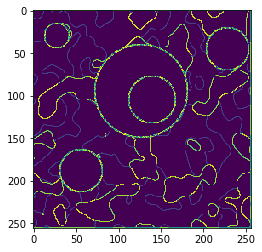

In [21]:
image_edges = cv2.imread('lab5.png')
image_edges = roberts_edges(image_edges)
plt.imshow(image_edges)

In [52]:
# img - obraz w formacie uint8 z wykrytymi krawedziami
# rp - roznica promieni. jaki zakres promieni ma sie liczyc jako jeden promien 
# prog - jaka czesc punktow musi trafic do akumulatora aby zaliczyc kolo
# radius - zakres wykrywanych promieni 
# rw - roznica wspolrzednych. jak duze odstepy pomiedzy srodkami kolek maja byc liczone jako jedno kolko
def wykryjOkregi(img, rp, prog, radius, rw):
    (M,N) = img.shape
    [R_min, R_max] = radius
    R = R_max - R_min
    # znajdz wspolrzedne krawedzi
    krawedzie = np.argwhere(img[:,:])
    # wylicz stopnie (raczej radiany)
    stopnie = np.arange(0,360)*np.pi/180
    # akumulator i wynik o rozmiarze powiekszonym o najwieksze promienie (kola niemieszczace sie w calosci w obrazie)
    accumulator = np.zeros((R_max,M+2*R_max,N+2*R_max))
    wynik = np.zeros((R_max,M+2*R_max,N+2*R_max))
    
    for val in range(R):
        r = R_min + val
        # tablica na szablon kola
        # dwa razy wieksza niz promien, bo kolo moze byc uciete na obrazku
        # wypelniamy tylko jeden szablon dla danego promienia
        # skraca to czas dzialania algorytmu
        szablon_kola = np.zeros((2*(r+1),2*(r+1)))
        # srodek szablonu kola
        (m,n) = (r+1,r+1)
        # rysowanie kola w szablonie kola
        for stopien in stopnie:
            x = int(np.round(r*np.cos(stopien)))
            y = int(np.round(r*np.sin(stopien)))
            szablon_kola[m+x,n+y] = 1
        # zlicza ilosc pikseli dla narysowanego szablonu kola
        # uzywane do okreslania jak duza wartosc powinien miec akumulator
        ilosc_pikseli_na_kolo = np.argwhere(szablon_kola).shape[0]
        
        for x,y in krawedzie:
            # wysrodkowywanie szablonu kola nad wykryta krawedzia
            # minimalne/maksymalne wartosci na osi X/Y
            # wspolrzedna krawedzi +- srodek szablonu kola + maksymalny promien
            X = [x-m+R_max,x+m+R_max]
            Y = [y-n+R_max,y+n+R_max]
            # szablon na poziomie r (aktualnie liczony promien) zwiekszamy o 1 w miejscu kola
            accumulator[r,X[0]:X[1],Y[0]:Y[1]] += szablon_kola
        
        # zerujemy akumulator w miejscach gdzie nie zostal przekroczony podany prog
        accumulator[r][accumulator[r]<ilosc_pikseli_na_kolo*prog] = 0

    # dla kazdego promienia i wspolrzednych
    for r,x,y in np.argwhere(accumulator):
        temp = accumulator[r-rp:r+rp,x-rw:x+rw,y-rw:y+rw]
        try:
            # maksymalna wartosc z przedzialu promieni i wspolrzednych
            # szukamy wspolrzednych maksymalnego
            p,a,b = np.unravel_index(np.argmax(temp), temp.shape)
        except:
            continue
            
        # promien + numer poziomu w ktorym byla maksymalna wartosc z zakresu poziomow - roznica poziomow
        # zaznaczanie srodka okregu
        wynik[r+(p-rp),x+(a-rw),y+(b-rw)] = 1

    return wynik[:,R_max:-R_max,R_max:-R_max]

In [50]:
def wyswietlOkregi(img, A):
    #img = cv2.medianBlur(img,5)
    # konwersja obrazu na odcienie szarosci
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    wspolrzedneOkregow = np.argwhere(A)
    for r,y,x in wspolrzedneOkregow:
        print(x, y, r)
        cv2.circle(img,(x,y),r,(255,0,0),2)
        cv2.circle(img,(x,y),2,(0,130,130),3)
    plt.imshow(img)

28 29 15
228 45 25
56 188 25
139 104 28
127 94 54


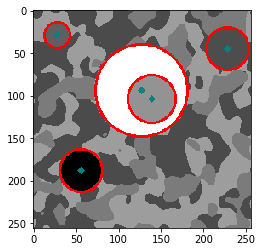

In [53]:
# Wczytanie obrazka
img = cv2.imread('lab5.png',0)
koleczka = wykryjOkregi(image_edges, 5, 0.7, [15, 55], 5)
wyswietlOkregi(img, koleczka)